# <font style = "color:rgb(50,120,229)">Skin Smoothing</font>

In previous modules we have seen how we can use grabcut for detecting skin region given the image of a face. The detected skin can then be smoothened and applied back to the original image, thereby resulting in a skin smoothened image. 

In this project, you will be implementing **Skin Smoothing** but this time the image will contain regions other than face as well and will have to be completely automated.

You can use the following steps to approach this problem:

1. Detect the faces in the image using Deep Learning or HAAR Cascades
2. Iterate over the detected faces and apply smoothing filter. You can experiment with the filter type and size to see which one (or combination) gives the best result.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
# Read image
img = cv2.imread(DATA_PATH + "images/hillary_clinton.jpg")

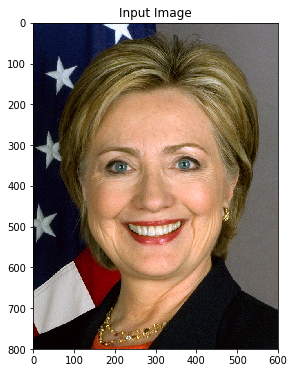

In [4]:
plt.imshow(img[:,:,::-1])
plt.title("Input Image")
plt.show()

In [5]:
MODEL_PATH = "../resource/lib/public/models/"

DNN = "TF"
if DNN == "CAFFE":
    modelFile = MODEL_PATH + "res10_300x300_ssd_iter_140000_fp16.caffemodel"
    configFile = MODEL_PATH + "deploy.prototxt"
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
else:
    modelFile = MODEL_PATH + "opencv_face_detector_uint8.pb"
    configFile = MODEL_PATH + "opencv_face_detector.pbtxt"
    net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

In [6]:
def detectFaceOpenCVDnn(net, frame):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    if DNN == "CAFFE":
        blob = cv2.dnn.blobFromImage(
            frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False,
        )
    else:
        blob = cv2.dnn.blobFromImage(
            frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False,
        )

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold and detections[0,0,i,5] < 1: # add additional check to detect face in the picture
            #print(detections[0,0,i])
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (255, 0, 0), int(round(frameHeight / 150)))
    return frameOpencvDnn, bboxes

def applySkinSmooth(im, low, up):
    cvtImg = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    skinMask = cv2.inRange(cvtImg, low, up)

    # apply a series of erosions and dilations to the mask
    # using an elliptical kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    #skinMask = cv2.dilate(skinMask, kernel, iterations = 1)

    # blur the mask to help remove noise, then apply the
    # mask to the frame
    #skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
    skin = cv2.bitwise_and(im, im, mask = skinMask)
    
    # diameter of the pixel neighbourhood used during filtering
    dia=15;
    # Larger the value the distant colours will be mixed together 
    # to produce areas of semi equal colors
    sigmaColor=35
    # Larger the value more the influence of the farther placed pixels 
    # as long as their colors are close enough
    sigmaSpace=80
    # Apply bilateralFilter
    result = cv2.bilateralFilter(skin, dia, sigmaColor, sigmaSpace)
    #plt.imshow(result[:,:,::-1])
    # Make the dimensions of the mask same as the input image.
    mask = cv2.merge((skinMask,skinMask,skinMask))
    # Use the mask to create the masked skin region
    face = cv2.subtract(im, mask)
    face = cv2.add(face, result)
    return face

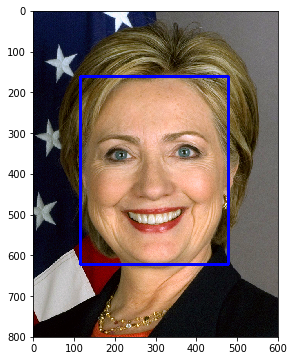

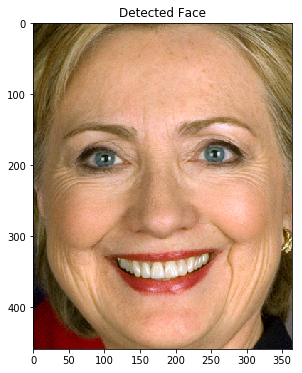

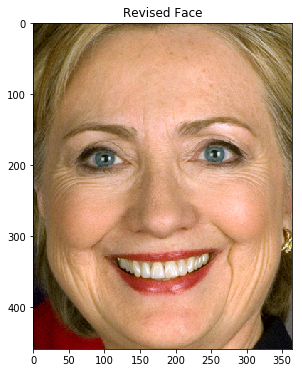

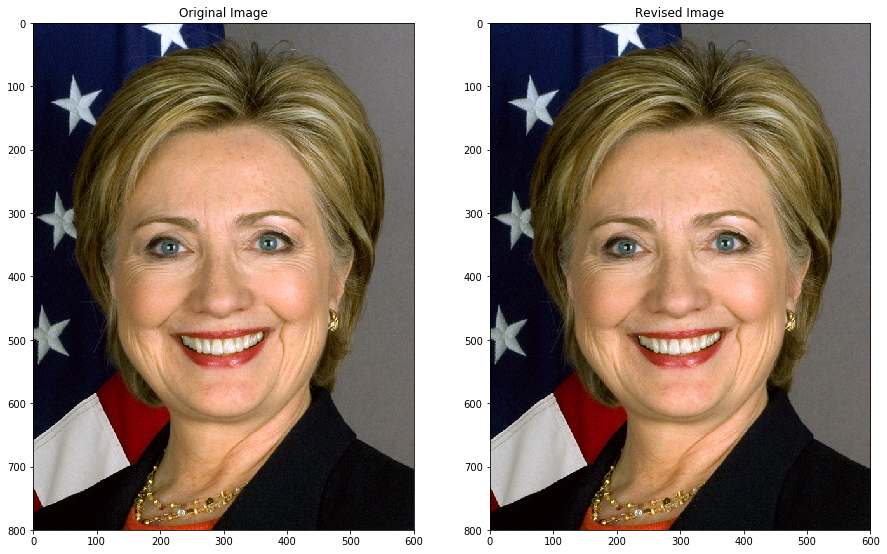

In [7]:
conf_threshold = 0.8
output,bboxes = detectFaceOpenCVDnn(net, img)
plt.imshow(output[:,:,::-1])

faceImg = img[bboxes[0][1]:bboxes[0][3],bboxes[0][0]:bboxes[0][2]]
plt.figure(figsize=[6,6])
plt.imshow(faceImg[:,:,::-1]);plt.title('Detected Face');

faceHeight = faceImg.shape[0]
faceWidth = faceImg.shape[1]
forehead = faceImg[int(faceHeight/6):int(faceHeight/4), int(faceWidth/6):int((faceWidth*5)/6)]

lower = np.array([forehead[..., 0].min(), forehead[..., 1].min(), forehead[..., 2].min()], dtype = "uint8")
upper = np.array([forehead[..., 0].max(), forehead[..., 1].max(), forehead[..., 2].max()], dtype = "uint8")

plt.figure(figsize=[6,6])
rev_face = applySkinSmooth(faceImg, lower, upper)
plt.imshow(rev_face[:,:,::-1]);plt.title('Revised Face');

plt.figure(figsize=[15,15])
plt.subplot(121);plt.imshow(img[:,:,::-1]);plt.title('Original Image');
rev_img = applySkinSmooth(img, lower, upper)
plt.subplot(122);plt.imshow(rev_img[:,:,::-1]);plt.title('Revised Image');

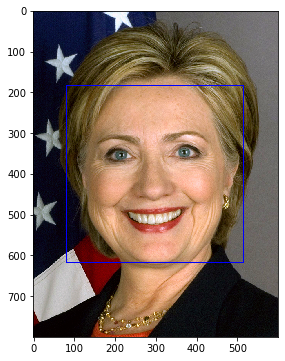

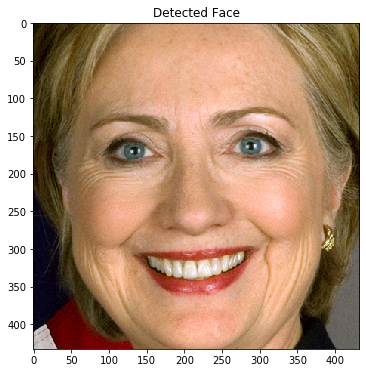

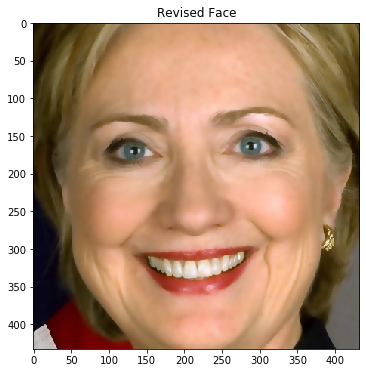

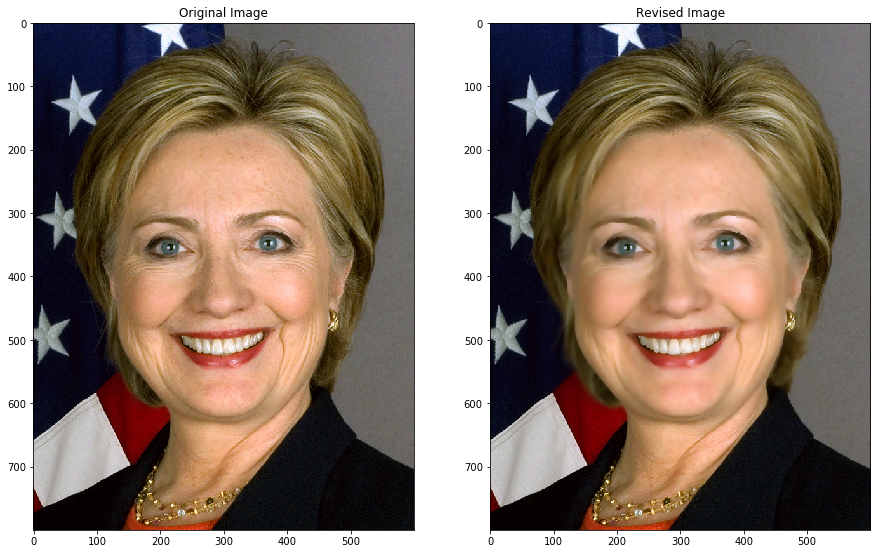

In [5]:
###
### YOUR CODE HERE
###
